In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
# import plotly.graph_objects as go
# import plotly.figure_factory as ff
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
# from nltk.tokenize import word_tokenize as wt 
# from collections import Counter
import gensim
# import textblob
import spacy
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM

In [3]:
print(tf. __version__)

2.10.0


### **Plan of Action**

- Load the data
- Drop unnecessary columns and rows
- Removal of stop words.
- Feature engineering;
    - Glove-twitter-200
- Begin modelling
    - Algorithms to use;
        - Simple Neural Network
- Evaluation;
    - F1-score_macro
    - AUC
    - ROC

In [4]:
df_clean = pd.read_csv('../../cleaned_reviews.csv')

In [5]:
df_clean.shape

(17340, 4)

In [6]:
df_clean.columns

Index(['sentiments', 'cleaned_review', 'cleaned_review_length',
       'review_score'],
      dtype='object')

In [7]:
df_clean.drop(columns=['cleaned_review_length','review_score'],inplace=True)

**Checking for Null Vaules and Duplicates**

In [8]:
df_clean.isna().sum()

sentiments        0
cleaned_review    3
dtype: int64

In [9]:
df_clean.dropna(inplace=True)

In [10]:
df_clean.shape

(17337, 2)

In [11]:
from spacy.lang.en.stop_words import STOP_WORDS

# print(STOP_WORDS,'\n') # <- set of Spacy's default stop words
all_stopwords = STOP_WORDS
# Adding several stopwords
# all_stopwords |= {'not',"no", "n't", 'n’t','n‘t','cannot','none','without','against'}

# Removing several stop words
all_stopwords-= {'not',"no", "n't", 'n’t','n‘t','cannot','none','without','against','off','against','too'}
my_stop_words = set(all_stopwords) # My own stop words

In [12]:
# print(my_stop_words)

In [13]:
df_clean

,sentiments,cleaned_review
0,positive,i wish would have gotten one earlier love it a...
1,neutral,i ve learned this lesson again open the packag...
2,neutral,it is so slow and lags find better option
3,neutral,roller ball stopped working within months of m...
4,neutral,i like the color and size but it few days out ...
...,...,...
17335,positive,i love this speaker and love can take it anywh...
17336,positive,i use it in my house easy to connect and loud ...
17337,positive,the bass is good and the battery is amazing mu...
17338,positive,love it


In [14]:
nlp = spacy.load("en_core_web_sm")

In [15]:
def spacy_tokeniser(sent):
    sent = sent.strip().lower()
    doc = nlp(sent)
    mytokens = [token.lemma_ for token in doc if token.text not in my_stop_words]
    return mytokens

In [16]:
df_clean['tokens']= df_clean['cleaned_review'].apply(spacy_tokeniser)

In [17]:
df_clean.head()

,sentiments,cleaned_review,tokens
0,positive,i wish would have gotten one earlier love it a...,"[wish, get, early, love, make, work, laptop, e..."
1,neutral,i ve learned this lesson again open the packag...,"[ve, learn, lesson, open, package, use, produc..."
2,neutral,it is so slow and lags find better option,"[slow, lag, find, well, option]"
3,neutral,roller ball stopped working within months of m...,"[roller, ball, stop, work, month, minimal, use..."
4,neutral,i like the color and size but it few days out ...,"[like, color, size, day, return, period, not, ..."


In [18]:
# Dropping unnecessary columns
df_clean.drop(columns=['cleaned_review'],inplace=True)

**Sentiment Mapping**

In [19]:
# Mapping was changed due to the use of a neural network architecture
sentiment_mapping = {'negative':0,'neutral':1,'positive':2} 
df_clean['sentiment_label'] = df_clean.sentiments.map(sentiment_mapping)

In [20]:
df_clean.drop(columns=['sentiments'],inplace=True)

**Text Sequencing**

Now we tokenize the sentences and convert X into sequences of numbers:
- Embedding layer expects the words to be in numeric form 
- Using Tokenizer function from keras.preprocessing.text library
- Method fit_on_text trains the tokenizer 
- Method texts_to_sequences converts sentences to their numeric form

In [21]:
X = df_clean["tokens"]

In [22]:
X[0]

['wish', 'get', 'early', 'love', 'make', 'work', 'laptop', 'easy']

In [23]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X)

X = word_tokenizer.texts_to_sequences(X)
X[0]

[153, 26, 758, 9, 124, 1, 51, 34]

In [24]:
# We need to find the maximum lenght of any document or review in our case. 
# We will pad all reviews to have this same length.
# This will be required by Keras embedding layer

review_max_length = 0
for i in df_clean['tokens']: 
    length = len(i)
    if length > review_max_length:
        review_max_length = length

print(review_max_length) 

# Although max length is 293, we will use an approximate value of 300; 
# maxlen = 300

293


In [25]:
# print(word_tokenizer.word_index) # Outputs a dictionary
len(word_tokenizer.word_index)

7258

In [26]:
vocab = word_tokenizer.word_index.items()

In [27]:
# print(vocab)
# Outputs a dict_items like so dict_items([('work', 1), ('mouse', 2)])

# for word, index in vocab:
#     print(f"The word: {word}") # The word: work

In [28]:
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

7259

In [29]:
max_len = 300
X = pad_sequences(X,padding="post",maxlen=max_len)

In [30]:
X[1].shape # shape
X[1].ndim # dimension

1

### **Creating Embedding Matrix**

In [31]:
import pickle
# Loading saved word2vec glove_twitter_25.pkl
vectorizer = pickle.load(open('../../../../../word2vec_files/glove_twitter_200.pkl', "rb"))

In [32]:
len(vectorizer.key_to_index.keys()) 

1193514

In [33]:
# print(list((vectorizer.key_to_index.keys()))) 
# # prints a list of keys like so ['<user>', '.', ':', 'rt', ',]

In [34]:
# vectorizer["model"] # Gives vector representation

In [35]:
# Create Embedding Matrix having 200 columns 
# Containing 200-dimensional GloVe word embeddings for all words in our corpus

w2v_vector_size = vectorizer.vector_size
embedding_matrix = np.zeros((vocab_length, w2v_vector_size)) 
# print(embedding_matrix.shape) # (7259, 200)
# print(embedding_matrix.ndim) # 2-dimensional array

In [36]:
embedding_matrix[:5,:2]

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [37]:
for word, index in vocab:
    if word in vectorizer.key_to_index.keys():
        embedding_matrix[index] = vectorizer[word]
    else:
        embedding_matrix[index] = np.zeros(w2v_vector_size)

In [38]:
# embedding_matrix.shape # (7259, 200)
# embedding_matrix.ndim # 2-dimensional array

In [39]:
embedding_matrix[:10,:10]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.25128999, -0.32295001,  0.29076001, -0.074966  , -0.042109  ,
         0.22063001,  1.023     , -0.032588  ,  0.035311  , -0.018864  ],
       [ 0.41170999, -0.39579001,  0.35874   ,  0.61809999, -0.066579  ,
         0.47218001,  0.80032003, -0.019318  ,  0.5898    , -0.83706999],
       [-0.099554  ,  0.12503   , -0.16867   ,  0.33724999, -0.59456998,
         0.48227   ,  0.78803998,  0.093338  , -0.096654  ,  0.28545001],
       [ 0.10751   ,  0.15958001,  0.13332   ,  0.16642   , -0.032737  ,
         0.17591999,  0.72395003,  0.11713   , -0.35036001, -0.42936999],
       [-0.26067999,  0.62687999, -0.013203  ,  0.21834999,  0.37790999,
         0.35712999,  0.49437001, -0.57717001,  1.10710001,  0.22645999],
       [ 0.0033451 ,  0.18548   ,  0.11773   ,  0.14827999,  0.012996  ,
        -0.35578001,  1.11619997, -0.069614  

### **Model Building**

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
# https://stackoverflow.com/questions/61550026/valueerror-shapes-none-1-and-none-3-are-incompatible

In [42]:
# y_nn = tf.keras.utils.to_categorical(df_clean['sentiment_label'], num_classes=3, dtype='int8')
y_nn = tf.keras.utils.to_categorical(df_clean.sentiment_label.values, num_classes=3, dtype='int8')

In [43]:
X_train, X_test, y_train,y_test= train_test_split(
                                            X,y_nn,test_size=.2,random_state=42, 
                                            stratify=y_nn)
# The train set will be used to train our deep learning models 
# while test set will be used to evaluate how well our model performs 

In [44]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length,w2v_vector_size,weights=[embedding_matrix],
                                        input_length=max_len,trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))
lstm_model.add(Dense(3,activation='softmax'))

# Initial error faced;
# NotImplementedError: Cannot convert a symbolic 
# Tensor (lstm/strided_slice:0) to a numpy array. 
# This error may indicate that you're trying to pass a 
# Tensor to a NumPy call, which is not supported


# Solution
# Rasied question
# https://stackoverflow.com/questions/70700626/this-error-may-indicate-that-youre-trying-to-pass-a-tensor-to-a-numpy-call-whi

# Given solution 
# https://stackoverflow.com/questions/66207609/notimplementederror-cannot-convert-a-symbolic-tensor-lstm-2-strided-slice0-t
# Modification of ops.py in the filepath "Lib/site-packages/tensorflow/python/framework/ops.py"
# Original code in lines 845-848
# def __array__(self):
#     raise NotImplementedError(
#         "Cannot convert a symbolic Tensor ({}) to a numpy array."
#         " This error may indicate that you're trying to pass a Tensor to"
#         " a NumPy call, which is not supported".format(self.name))

# Modified code
# def __array__(self):
#     raise TypeError(
#         "Cannot convert a symbolic Tensor ({}) to a numpy array."
#         " This error may indicate that you're trying to pass a Tensor to"
#         " a NumPy call, which is not supported".format(self.name))

# Second solution 
# Tensorflow 2.3.0 is not compatible with numpy 1.23.1
# Upgrade tensorflow to 2.5.o or 2.10
# If you installed with conda
# Kindly remove tensorflow using "conda remove tensorflow"
# Install tensorflow the right way using the following;
# Using pip install tensorflow==2.5.0 or
# Using pip install tensorflow==2.10
# https://stackoverflow.com/questions/45425896/install-tensorflow-with-specific-version-on-anaconda

# In case you face this issue after following the above;
# Import Spacy Error "cannot import name dataclass_transform" (when importing spacy)
# Use this to rectify it "conda install -c conda-forge spacy"
# This will fix the main issue which is typing_extensions compatibility issue
# upgrading it from 3.7.4.3 to 4.4.0 or 
# rather installing a newtyping_extensions dependency with version number 4.4.0

In [47]:
# LSTM
# https://stackoverflow.com/questions/38080035/how-to-calculate-the-number-of-parameters-of-an-lstm-network

# Embedding/input layer
# output_size * (input_size+1)

# LSTM
# num_params = ([(num_units + input_dim + 1) * num_units] * 4) *2

# Dense layer
# number_of_classes * (input_size+1)

assert 200 *vocab_length==1451800 # Embedding layer [17529*200]
assert ((128 + (200 + 1)) * 128) * 4 == 168448 # LSTM layer
assert 3 * (128+1) == 387 # Dense layer num_class * (128+1)

In [46]:
lstm_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 200)          1451800   
                                                                 
 lstm (LSTM)                 (None, 128)               168448    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 1,620,635
Trainable params: 168,835
Non-trainable params: 1,451,800
_________________________________________________________________
None


In [48]:
# Model training

lstm_model_history = lstm_model.fit(
    X_train,y_train,batch_size=128,epochs=10, verbose=1, validation_split=.2
)

Epoch 1/10
87/87 [==============================] - 41s 223ms/step - loss: 0.9378 - acc: 0.5444 - val_loss: 0.9204 - val_acc: 0.5397
Epoch 2/10
87/87 [==============================] - 22s 252ms/step - loss: 0.9110 - acc: 0.5502 - val_loss: 0.9217 - val_acc: 0.5397
Epoch 3/10
87/87 [==============================] - 18s 213ms/step - loss: 0.9120 - acc: 0.5502 - val_loss: 0.9219 - val_acc: 0.5397
Epoch 4/10
87/87 [==============================] - 18s 213ms/step - loss: 0.9126 - acc: 0.5502 - val_loss: 0.9201 - val_acc: 0.5397
Epoch 5/10
87/87 [==============================] - 19s 214ms/step - loss: 0.9120 - acc: 0.5502 - val_loss: 0.9194 - val_acc: 0.5397
Epoch 6/10
87/87 [==============================] - 19s 214ms/step - loss: 0.9112 - acc: 0.5502 - val_loss: 0.9200 - val_acc: 0.5397
Epoch 7/10
87/87 [==============================] - 18s 213ms/step - loss: 0.9120 - acc: 0.5502 - val_loss: 0.9195 - val_acc: 0.5397
Epoch 8/10
87/87 [==============================] - 18s 213ms/step - 

In [49]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

109/109 [==============================] - 4s 33ms/step - loss: 0.9144 - acc: 0.5482


In [50]:
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.9143531918525696
Test Accuracy: 0.5481545329093933


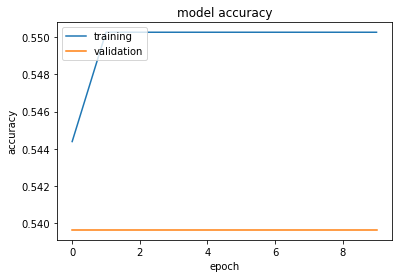

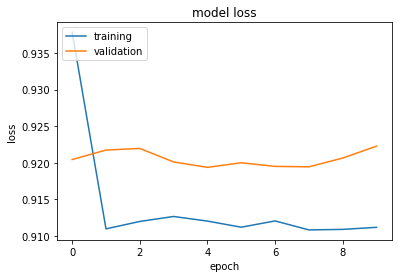

In [51]:
# Model Performance Charts

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='upper left')
plt.show()

### **Classification report**

109/109 [==============================] - 39s 364ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       307
           1       0.00      0.00      0.00      1260
           2       0.55      1.00      0.71      1901

    accuracy                           0.55      3468
   macro avg       0.18      0.33      0.24      3468
weighted avg       0.30      0.55      0.39      3468



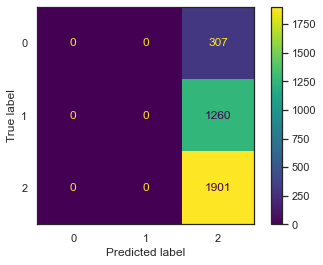

In [53]:
# Classification report test data
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
y_true=np.argmax(y_test, axis=1)
y_pred_test = lstm_model.predict(X_test)
y_pred_test=np.argmax(y_pred_test, axis=1)
sns.set_theme(style='white')
def class_report(model,y_true,pred):
    print(classification_report(y_true,pred))
    cm = confusion_matrix(y_true,pred,labels=[0,1,2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2])
    disp.plot()
    plt.show()


class_report(lstm_model,y_true,y_pred_test) 

# Original mapping
# sentiment_mapping = {'negative':-1,'neutral':0,'positive':1}

# New mapping
# negative --> 0
# neutral --> 1
# positive --> 2

### **ROC Curve**

In [54]:
from sklearn.preprocessing import label_binarize

In [55]:
n_classes = 3

y_nn_auc = label_binarize(y_nn, classes=[0,1,2])

n_classes = y_nn_auc.shape[1]

In [56]:
y_nn_auc
# y_nn
# Same output
 
# array([[0, 0, 1],
#        [0, 1, 0],
#        [0, 1, 0],
#        ...,
#        [0, 0, 1],
#        [0, 0, 1],
#        [0, 1, 0]])

array([[0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0]])

In [57]:
X_train, X_test, y_train,y_test= train_test_split(
                                            X,y_nn_auc,test_size=.2,random_state=42, 
                                            stratify=y_nn_auc)

In [58]:
len(X)

17337

In [60]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length,w2v_vector_size,weights=[embedding_matrix],
                                        input_length=max_len,trainable=False)


lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))
lstm_model.add(Dense(3,activation='softmax'))
lstm_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

print(lstm_model.summary())
# Model training

lstm_model_history = lstm_model.fit(
    X_train,y_train,batch_size=128,epochs=10, verbose=1, validation_split=.2
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 200)          1451800   
                                                                 
 lstm_2 (LSTM)               (None, 128)               168448    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1,620,635
Trainable params: 168,835
Non-trainable params: 1,451,800
_________________________________________________________________
None
Epoch 1/10
87/87 [==============================] - 290s 3s/step - loss: 0.9418 - acc: 0.5447 - val_loss: 0.9192 - val_acc: 0.5397
Epoch 2/10
87/87 [==============================] - 13032s 152s/step - loss: 0.9114 - acc: 0.5502 - val_loss: 0.9221 - val_acc: 0.5397
Epoch 3/10
87/87 [=============

In [61]:
from sklearn.metrics import roc_curve, roc_auc_score,auc

In [62]:
fpr = {}
tpr = {}
roc_auc = {}
# Plot linewidth
lw = 2

# Version 2
classes_by_names = ["negative","neutral","positive"]
def roc_curve_plot(value,y_test):
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:,i], 
                                                    value[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])                                                    
        plt.plot(fpr[i], tpr[i], lw=lw, label= "ROC of class {}, AUC= {}"
        .format(classes_by_names[i],np.round(roc_auc[i],2)))
        
       
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="best",frameon=True) # ,labels=["negative","neutral","positive"]
    # Title should be modified
    plt.title("ROC curve of Simple Neural Network multiclass; Sentiment prediction")
    plt.show()
    roc_auc_scoring_macro_ovr = roc_auc_score(y_test,value, multi_class="OvR",average='macro')
    print("AUC macro-averaged over all classes: {:.2f}"
    .format(roc_auc_scoring_macro_ovr))

In [63]:
y_pred_test = lstm_model.predict(X_test)
# y_pred_test=np.argmax(y_pred_test, axis=1)

109/109 [==============================] - 3s 23ms/step


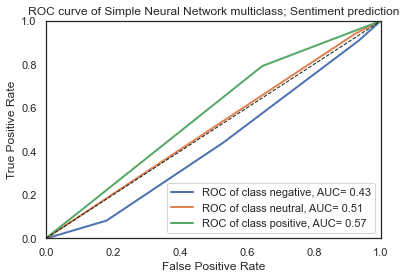

AUC macro-averaged over all classes: 0.51


In [64]:
roc_curve_plot(y_pred_test,y_test)

## **Conclusion**

- Using glove-twitter-200 word embeddings with a LSTM has shown terrible performance even the use of traditional ML algo is so much better.
- Maybe the addition of more layers could help or the the use of bidirectional LSTM?
- HistGradientBoostingClassifier using Glove-twitter-200 has an f1-score of 0.78 and AUC score of 0.95.


**Table of Values**

dataset|f1_score_macro_avg|AUC_score_avg
| ----------- | ----------- | ----------- |
df_clean (test data)|0.24|0.51